<a href="https://colab.research.google.com/github/greyhound101/IEEE-CIS-Fraud/blob/master/simple_model_with_uid_embedding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading libraries

In [ ]:
import pandas as pd
from tensorflow.keras.layers import *
import tensorflow as tf
import random, os, sys
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
import tensorflow as tf
from google.colab import drive
import os
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from keras.layers import *
from keras.optimizers import *
from keras.models import *
from keras import backend as K
from tensorflow.keras.models import *
import tensorflow.keras.backend as K
from tensorflow.keras.layers import *
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback
import gc

In [ ]:

os.environ['KAGGLE_USERNAME'] = "tapaskd123" # username from the json file
os.environ['KAGGLE_KEY'] = "aba8dc1f085221111d925003fe5a88ed" # key from the json file
!kaggle competitions download -c ieee-fraud-detection

  0% 0.00/3.21M [00:00<?, ?B/s]
100% 3.21M/3.21M [00:00<00:00, 106MB/s]
  0% 0.00/3.26M [00:00<?, ?B/s]
100% 3.26M/3.26M [00:00<00:00, 222MB/s]
 58% 30.0M/52.2M [00:00<00:00, 313MB/s]
100% 52.2M/52.2M [00:00<00:00, 255MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 37.7MB/s]
 98% 57.0M/58.3M [00:00<00:00, 192MB/s]
100% 58.3M/58.3M [00:00<00:00, 168MB/s]


loading drive

In [ ]:

drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
Mounted at /content/gdrive


Loading dataframes

In [ ]:

trn=pd.read_csv('/content/gdrive/My Drive/fraud/train.csv',index_col=[0])
tst=pd.read_csv('/content/gdrive/My Drive/fraud/test.csv',index_col=[0])
trn.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,V1,isna_sum,dist1_isna,dist2_isna,D1_isna,D2_isna,D3_isna,D4_isna,D5_isna,D6_isna,D7_isna,D8_isna,D9_isna,D10_isna,D11_isna,D12_isna,D13_isna,D14_isna,D15_isna,V1_isna,id,isFraud
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319736,-0.752856,-0.429362,0.155508,0.000000,0.312997,0.0,0.000000,0.0,0.0,0.0,0.0,-0.012922,-0.737091,0.0,0.0,0.0,-0.807711,0.00739,-0.167776,0,1,0,1,0,1,1,1,1,1,1,0,0,1,1,1,0,0,1.01.0nan315.013926-13.0,0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319736,-0.752856,-0.429362,-0.942090,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-1.038619,0.000000,0.0,0.0,0.0,-0.807711,0.00000,1.349188,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,0,1,1.01.0gmail.com325.027551.0,0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319736,-0.752856,-0.429362,-0.942090,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-1.038619,1.132473,0.0,0.0,0.0,0.746105,0.00739,0.211465,0,1,0,1,1,1,1,1,1,1,1,0,0,1,1,1,0,0,1.01.0outlook.com330.046631.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319736,1.013560,-0.429362,0.973965,0.292248,-1.335951,0.0,-1.301712,0.0,0.0,0.0,0.0,0.688064,0.000000,0.0,0.0,0.0,-0.260176,0.00000,0.211465,1,1,0,0,0,1,0,1,1,1,1,0,1,1,1,1,0,1,2.025.0yahoo.com476.018132-111.0,0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.319736,-0.752856,-0.429362,-0.942090,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.00000,2.107669,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1.01.0gmail.com420.044971.0,0


Reduce memory useage

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df
trn=reduce_mem_usage(trn)
tst=reduce_mem_usage(tst)

Memory usage of dataframe is 2252.73 MB
Memory usage after optimization is: 580.70 MB
Decreased by 74.2%
Memory usage of dataframe is 1929.01 MB
Memory usage after optimization is: 500.58 MB
Decreased by 74.0%


In [ ]:
trn=trn.replace([np.inf,-np.inf],np.nan)
tst=tst.replace([np.inf,-np.inf],np.nan)
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=trn.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(trn[col].mean())
  tst[col]=tst[col].fillna(tst[col].mean())
a=tst.isna().sum()
ls=a[a>0].index
for col in ls:
  trn[col]=trn[col].fillna(0)
  tst[col]=tst[col].fillna(0)

Making the callbacks and loading model

In [ ]:
dk={}
class RocCallback(Callback):
    def __init__(self,validation_data):
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
        self.ep=0

    def on_train_begin(self, logs={}):
        return

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.ep+=1
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('roc-auc_val: %s' % str(round(roc_val,4)))

    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
def load_model():
  K.clear_session()


  uid=Input((1,))
  inp=Input((497,))
  emb=Embedding(input_dim=485912,output_dim=4)(uid)
  emb=Flatten()(emb)
  x=Dense(256,activation=custom_gelu)(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation=custom_gelu)(inp)
  x=BatchNormalization()(x)
  x=Dropout(0.3)(x)
  x=Dense(256,activation=custom_gelu)(x)
  x=Dropout(0.3)(x)
  emb=Dense(256)(emb)
  x=Add()([emb,x])
  x=Dense(1,activation='sigmoid')(x)
  mod=Model(inputs=[inp,uid],outputs=x)
  return mod

def custom_gelu(x):
    return 0.5 * x * (1 + tf.tanh(tf.sqrt(2 / np.pi) * (x + 0.044715 * tf.pow(x, 3))))

In [ ]:
from sklearn.model_selection import KFold
splits=KFold(n_splits=5)

In [ ]:
ids={}
for en,id in enumerate(trn['id'].unique()):
  ids[id]=en+2
trn['id']=trn['id'].map(lambda x: ids.get(x,1))
tst['id']=tst['id'].map(lambda x: ids.get(x,1))
gc.collect()

61

In [ ]:
ln=len(trn)/10
for i in range(6,10):
  X_train, X_test = trn.loc[:int(ln*i)], trn.loc[int(ln*i):]
  y_train, y_test = X_train['isFraud'], X_test['isFraud']
  trn_id,tst_id=X_train['id'],X_test['id']
  X_train=X_train.drop(['isFraud','id'],1)
  X_test=X_test.drop(['isFraud','id'],1)
  mod=load_model()
  roc = RocCallback(
                  validation_data=([X_test,tst_id], y_test))
  mod.compile(optimizer=Nadam(),loss='binary_crossentropy')
  es=EarlyStopping(monitor='val_loss',min_delta=0.0001,mode='min',restore_best_weights=True,patience=50)
  mod.fit([X_train,trn_id],y_train,validation_data=([X_test,tst_id],y_test),batch_size=2048,epochs=8,callbacks=[es,roc])
  gc.collect()
  mod.fit(X_test,,y_test,epochs=2,batch_size=2048)
  if en ==0:
    pre=mod.predict(tst.drop(['id'],tst['id']))/5
  else:
    pre+=mod.predict(tst.drop(['id'],tst['id'])/5
  del([X_train,X_test,y_train,y_test])
  gc.collect()

Epoch 1/8
174/174 [==============================] - 10s 58ms/step - loss: 0.1224 - val_loss: 0.1885
Epoch 2/8
174/174 [==============================] - 10s 55ms/step - loss: 0.0842 - val_loss: 0.1206
Epoch 3/8
174/174 [==============================] - 10s 55ms/step - loss: 0.0592 - val_loss: 0.1097
Epoch 4/8
174/174 [==============================] - 10s 56ms/step - loss: 0.0337 - val_loss: 0.1224
Epoch 5/8
174/174 [==============================] - 10s 55ms/step - loss: 0.0164 - val_loss: 0.1732
Epoch 6/8
174/174 [==============================] - 10s 55ms/step - loss: 0.0081 - val_loss: 0.1933
Epoch 7/8
174/174 [==============================] - 10s 55ms/step - loss: 0.0049 - val_loss: 0.2061
Epoch 8/8
174/174 [==============================] - 10s 55ms/step - loss: 0.0035 - val_loss: 0.2283
Epoch 1/2


AssertionError: ignored

In [ ]:
y_test

354324    0
354325    0
354326    0
354327    0
354328    0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 236216, dtype: int8

In [ ]:
sub=pd.read_csv('sample_submission.csv.zip')
sub['isFraud']=pre
sub=sub.set_index('TransactionID')
sub.head()

,isFraud
TransactionID,
3663549,0.002347
3663550,0.001571
3663551,0.000397
3663552,0.000376
3663553,0.000041


In [ ]:
sub.to_csv('sub.csv')

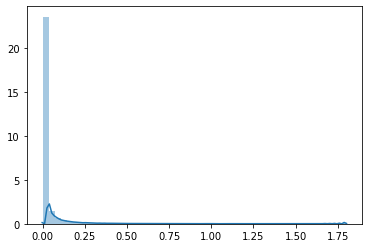

In [ ]:
import seaborn as sns
sns.distplot(pre)